# Truncated Skewed Levy Distribution

In [16]:
from levy_distribution import pdf_from_cf, dump_levy, load_levy
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import norm
import pandas as pd

In [2]:
mu = 0.0
c = 1.0
alpha = 1.212
lam = 0.02
beta = 0.09

## Evaluate at some points

In [3]:
x= [0.2, 2, -1]
pdf_from_cf(x,mu,c,alpha,lam,beta)

array([0.31770548, 0.09238534, 0.15254409])

## Make a plot
Takes around 4 seconds for 1000 points

It took 4.163009881973267 seconds for 1000 evaluations


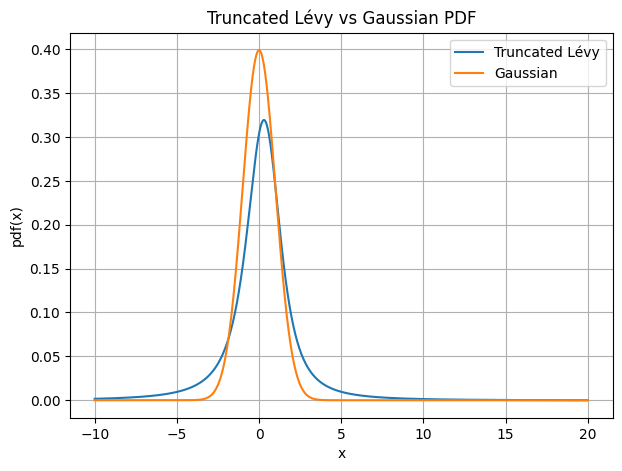

In [4]:
x_values = np.linspace(-10, 20, 1000)
start_time = time.time()
y_values = pdf_from_cf(x_values, mu, c, alpha, lam, beta)
print("It took %s seconds for 1000 evaluations" % (time.time() - start_time))
# It takes 4 seconds for 1000 evaluations

pdf_gaussian = norm.pdf(x_values, loc=mu, scale=c)
# Plot the resulting PDF:
plt.figure(figsize=(7, 5))
plt.plot(x_values, y_values, label='Truncated Lévy')
plt.plot(x_values, pdf_gaussian, label='Gaussian')

plt.title("Truncated Lévy vs Gaussian PDF")
plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.legend()
plt.grid(True)
plt.show()

## Dump the data points to a file
Takes 40 seconds for 10000 points

In [5]:
dump_levy(mu,c,alpha, lam, beta, x_min=-15, x_max=15, x_points=10000, filename='data/my_levy')

saved to: C:\Users\leocr\Projects\Economics\Finance\Risk Management\numerical_distributionsdata/my_levy_0.0_1.0_1.21_0.02_0.09.npz


## Reload the saved data points
This will give a scipy.stats distribution for the fixed parameters, which allows for various operations, like evaluating moments and also sampling

In [6]:
my_levy = load_levy('data/my_levy_0.0_1.0_1.21_0.02_0.09.npz')

In [7]:
sample = my_levy.rvs(size = 10000)

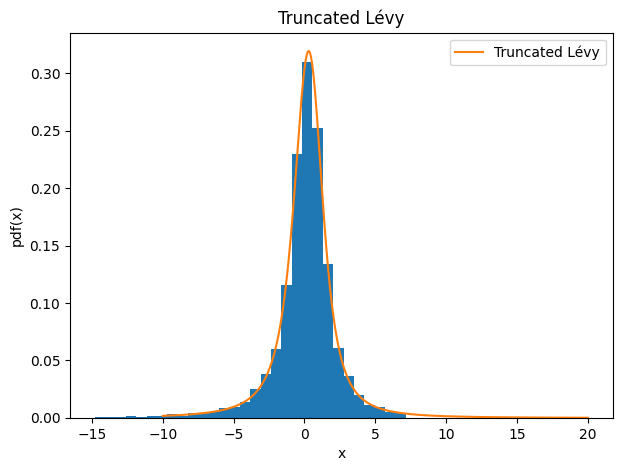

In [13]:
plt.figure(figsize=(7, 5))
plt.hist(sample, bins=30, density=True)
plt.plot(x_values, y_values, label='Truncated Lévy')
plt.title("Truncated Lévy")
plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.legend()
plt.show()

In [24]:
dfs = pd.read_excel('../EU_Data.xlsx', sheet_name=None)

euronext100 = dfs['Euronext100'][['Date', 'Close']]
stoxx50e = dfs['Stoxx50E'][['Date', 'Close']]

data = stoxx50e.copy()

data['Returns'] = data['Close'].dropna().pct_change()

std_dev = data['Returns'].std()
data['Scaled Returns'] = data['Returns']/std_dev

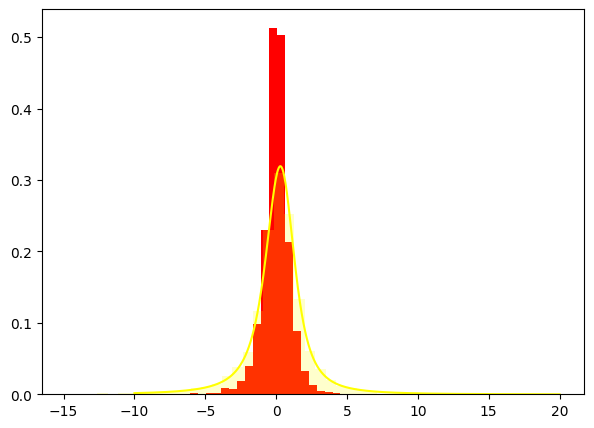

In [30]:
plt.figure(figsize=(7, 5))
plt.hist(data['Scaled Returns'], bins=30, density=True, color='red')
plt.hist(sample, bins=30, density=True, alpha=0.2, color='yellow')
plt.plot(x_values, y_values, label='Truncated Lévy', color='yellow')
plt.show()